# What is an R-Tree?

An R-tree is a data structure that is optimized for spatial access methods, essentially allowing for efficient querying of spatial objects. To explain how an R-tree works and why it's faster, especially in the context of spatial operations like intersecting a large number of polygons, let's delve into its characteristics:

1. **Hierarchical Structure**: R-trees are balanced tree data structures where each node represents a bounding box encompassing its child nodes. The leaf nodes contain pointers to the actual spatial objects (polygons, points, lines, etc.), while the internal nodes represent increasingly larger bounding boxes that encapsulate the bounds of their children.

2. **Bounding Box Organization**: The crucial feature of R-trees is the use of these bounding boxes (or bounding regions) to organize spatial data. Each bounding box is the smallest possible rectangle (or hyperrectangle in higher dimensions) that contains a set of spatial objects.

3. **Spatial Query Efficiency**: When a spatial query (such as intersection, proximity, or containment) is performed, the R-tree allows us to quickly eliminate large portions of the tree that are guaranteed not to intersect with the query's bounding box. This is because if the query box does not intersect with a particular bounding box in the tree, then it cannot possibly intersect with any of the children within that box. Therefore, all those children can be skipped.

4. **Minimizing Overlap**: During the construction of an R-tree, algorithms work to minimize the overlap between bounding boxes at the same level of the hierarchy. Minimizing overlap is crucial because it reduces the number of bounding boxes that must be checked during a spatial query.

5. **Logarithmic Time Complexity**: The traversal of an R-tree, because of its hierarchical nature, operates in logarithmic time relative to the number of items in the tree. This contrasts with a linear time complexity of checking every object against every other object without such an index.

## For cropping polygons

In the specific case of cropping polygons using a grid, each grid cell can be represented as a bounding box within the R-tree. When attempting to find which grid cells intersect with a particular polygon, the R-tree allows us to efficiently traverse the index and identify only the relevant cells. 

Without the R-tree, every grid cell would have to be checked against the polygon in question, which would require a significantly greater number of intersection tests, with a time complexity proportional to the product of the number of polygons and the number of grid cells. 

With an R-tree, we reduce this to a time complexity proportional to the **logarithm** of the number of grid cells times the number of polygons being processed, leading to substantial performance improvements, especially as the number of spatial objects grows large.

Visualizing how an R-tree works in a text-based environment is challenging, but I can describe a conceptual visualization you could create to understand R-trees better.

Imagine a series of overlapping geometric shapes on a plane, like polygons, which could represent different regions on a map. If you were to query which polygons intersect with a new shape (let's say a line or another polygon), without an R-tree, you would have to overlay this new shape on every single one of the existing shapes and check for intersections individually.

## The process

With an R-tree, you could visualize the process as follows:

1. **Bounding Boxes**: Start by drawing rectangles around each of your polygons. These rectangles should be as small as possible while still completely containing the polygon inside. These represent the leaf nodes of your R-tree.

2. **Hierarchy of Boxes**: Group these bounding boxes into larger bounding boxes that contain several smaller ones. Repeat this step until you have one single bounding box at the top, which contains all other boxes. This structure is your R-tree, where each box represents a node in the tree, and the single large box at the top is the root node.

3. **Searching the R-tree**: When you bring in your new shape to query the intersecting polygons, you start at the top of the R-tree. If the new shape intersects with the bounding box of the root node, you move one level down in the hierarchy to the child nodes (the larger bounding boxes containing groups of polygons).

4. **Traversing Downwards**: For each child node that intersects with the shape, you continue to move downwards in the tree, to the next level of even smaller bounding boxes, until you reach the leaf nodes.

5. **Intersection Check**: Only when you reach the leaf nodes, which contain the actual polygons, do you perform a detailed intersection check. If the bounding box at a leaf node does not intersect with the query shape, you can ignore the detailed check for the polygon inside that box.

6. **Visual Efficiency**: In a visual representation, you would see that you've skipped checking many polygons that are clearly far away from your query shape because their bounding boxes didn't intersect with the query shape at a higher level in the tree.

To illustrate this visually in a tool or software, you could create a step-by-step animation:

- Begin with all the polygons on the map.
- Overlay the hierarchical bounding boxes, showing the structure of the R-tree.
- Introduce the query shape (the line or polygon you're testing for intersections).
- Highlight the path through the R-tree that the algorithm takes as it checks for intersections, showing how non-intersecting branches are quickly discarded.

In [12]:
import geopandas as gpd
from shapely.geometry import Polygon
import random
import os

# Function to generate random polygons
def generate_random_polygon(offset):
    return Polygon([(random.uniform(-5, 5) + offset, random.uniform(-5, 5) + offset) for _ in range(5)])

# Generate a list of random polygons
polygons = [generate_random_polygon(i) for i in range(25)]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'id': range(len(polygons))}, geometry=polygons)

# Set the CRS (Coordinate Reference System) to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Save to a Shapefile
output_filename = '../data/out/sample_polygons.shp'
gdf.to_file(output_filename, driver="GeoJSON")

print(f"Sample shapefile created: {output_filename}")

Sample shapefile created: ../data/out/sample_polygons.shp


GeoDataFrame loaded successfully!
Checking spatial index...
Spatial index ready!
Query geometry defined.
Figure and axis created for plotting.
Plotting polygons...
Highlighting query geometry...
Finding possible matches with the query geometry...
Possible matches found: 8
Plotting bounding boxes of possible matches...
Finalizing plot...


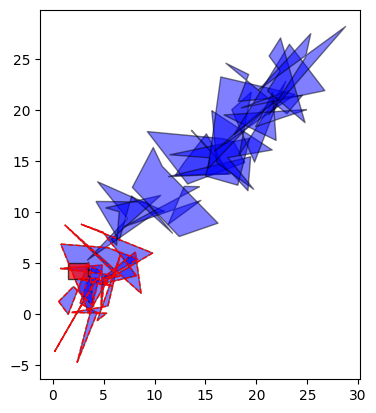

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

# Load your GeoDataFrame
gdf = gpd.read_file('../data/out/sample_polygons.shp')
print("GeoDataFrame loaded successfully!")

# Ensure it has the spatial index built (if not, it will be created automatically)
print("Checking spatial index...")
sindex = gdf.sindex
print("Spatial index ready!")

# Define a query geometry
query_geom = box(1.5, 5, 3.5, 3.5)
query_gdf = gpd.GeoDataFrame(geometry=[query_geom], crs=gdf.crs)
print("Query geometry defined.")

# Visualize the spatial index by plotting the bounding boxes of the indexed geometries
fig, ax = plt.subplots()
print("Figure and axis created for plotting.")

# Plot the geometries in the GeoDataFrame
print("Plotting polygons...")
gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)

# Highlight the query geometry
print("Highlighting query geometry...")
query_gdf.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

# Find the geometries that intersect with the query geometry
print("Finding possible matches with the query geometry...")
possible_matches_index = list(sindex.intersection(query_geom.bounds))
possible_matches = gdf.iloc[possible_matches_index]
print(f"Possible matches found: {len(possible_matches)}")

# Plot bounding boxes of the possible matches and label them
print("Plotting bounding boxes of possible matches...")
for i, geom in possible_matches.iterrows():
    x, y = geom.geometry.exterior.coords.xy
    bbox_patch = plt.Polygon(xy=list(zip(x, y)), fill=None, edgecolor='red', lw=1, linestyle='--')
    ax.add_patch(bbox_patch)
    # Annotate the bounding box with its index
    bbox_center_x = geom.geometry.centroid.x
    bbox_center_y = geom.geometry.centroid.y

print("Finalizing plot...")
plt.show()
